In [1]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

In [3]:
rootdir = "/home/akshayn/burrito"
outdirs = [ "lbench-8e899ec"]
datapaths = ['shenango', 'dpdk']
msg_sizes = [0, 128, 1024]
iters = 5

In [7]:
def read_exp(outdir, dp, ms):
    df = pd.DataFrame()
    for i in range(iters):
        fn = f"{rootdir}/{outdir}/{dp}-msg_size={ms}-{i}-lbench_client-10.1.1.6.data"
        try:
            df_iter = pd.read_csv(fn)
            df_iter["Outdir"] = outdir
            df_iter["Datapath"] = dp
            df_iter["MsgSize"] = ms
            df_iter["iter"] = i
            df = df.append(df_iter)
        except:
            pass
    return df

exps = None
for outdir in outdirs:
    for dp in datapaths:
        for ms in msg_sizes:
            df = read_exp(outdir, dp, ms)
            if exps is None:
                exps = df
            else:
                exps = exps.append(df)

exps = exps.groupby(["Outdir", "Datapath", "MsgSize"]).quantile([0.05, 0.25, 0.5, 0.75, 0.95])
exps = exps.unstack()
exps.columns = [f"{s}_{t}" for s,t in exps.columns.values]
exps.columns = exps.columns.to_flat_index()
exps = exps.reset_index()
exps

,Outdir,Datapath,MsgSize,Latency_us_0.05,Latency_us_0.25,Latency_us_0.5,Latency_us_0.75,Latency_us_0.95,iter_0.05,iter_0.25,iter_0.5,iter_0.75,iter_0.95
0,lbench-8e899ec,dpdk,0,16.0,17.0,19.0,21.0,24.0,0.0,1.0,2.0,3.0,4.0
1,lbench-8e899ec,dpdk,128,17.0,18.0,20.0,22.0,25.0,0.0,1.0,2.0,3.0,4.0
2,lbench-8e899ec,dpdk,1024,23.0,24.0,25.0,27.0,31.0,0.0,1.0,2.0,3.0,4.0
3,lbench-8e899ec,shenango,0,17.0,18.0,18.0,19.0,20.0,0.0,1.0,2.0,3.0,4.0
4,lbench-8e899ec,shenango,128,19.0,20.0,20.0,21.0,22.0,0.0,1.0,2.0,3.0,4.0
5,lbench-8e899ec,shenango,1024,25.0,26.0,27.0,28.0,31.0,0.0,1.0,2.0,3.0,4.0


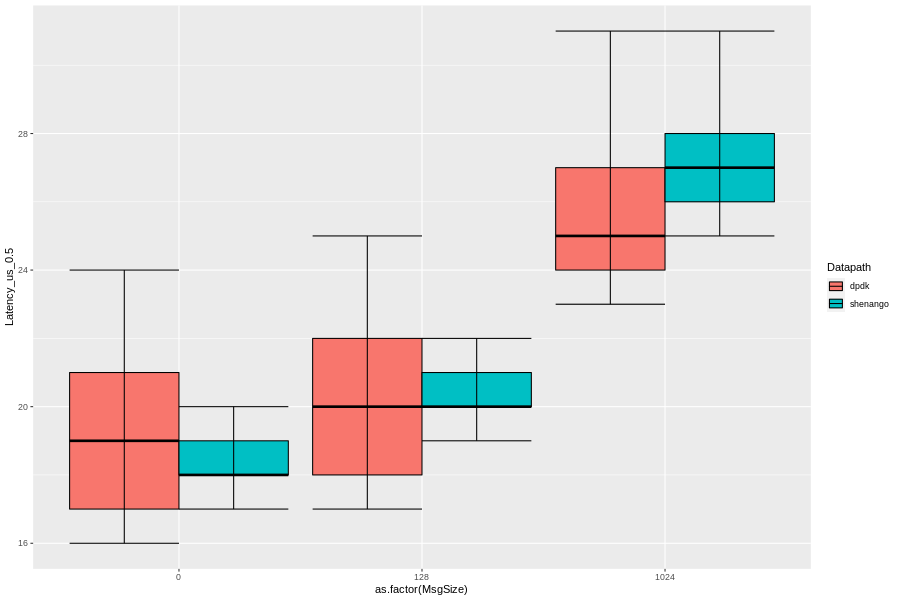

In [8]:
%%R -i exps -w 900 -h 600

library(ggplot2)

ggplot(exps, aes(x=as.factor(MsgSize), fill=Datapath)) +
  geom_crossbar(aes(ymin=Latency_us_0.25, y=Latency_us_0.5, ymax = Latency_us_0.75), position="dodge") +
  geom_errorbar(aes(ymin=Latency_us_0.05, ymax=Latency_us_0.95), position="dodge")